In [1]:
from env import github_token, github_username
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from os import path
from requests import get
from sklearn.model_selection import train_test_split
from typing import Dict, List, Optional, Union, cast
from wordcloud import WordCloud
import prepare as p

import json
import matplotlib.pyplot as plt
import nltk
import nltk.sentiment
import numpy as np
import os
import pandas as pd

import re
import requests
import seaborn as sns
import time
import unicodedata

In [2]:
large_scraped_data = pd.read_csv('large_scraped_data.csv')

In [3]:
large_scraped_data = large_scraped_data.dropna()

In [4]:
large_scraped_data = large_scraped_data.drop(columns='Unnamed: 0')

In [5]:
df=large_scraped_data

In [6]:
extra_stops = ['&#9;', "' ", " '", "'",'Minecraft','minecraft','minecraft ',' minecraft','abstract','and','arguments','assert','break','byte','case','char','class',
               'const','continue','default','double','else','enum','extends','false','final','finally','float','for',
               'goto','if','implements','import','in','instanceof','int','interface','long','native','new','null',
               'package','pass','private','protected','public','raise','return','short','static','super','switch',
               'synchronized','this','throw','throws','transient','true','try','void','volatile','while','with',
               'yield', 'http', 'com', 'github', 'www', 'version', 'file']

def prep_readme_data(df, column, extra_words=[], exclude_words=[]):
    '''
    This function take in a df and the string name for a text column with 
    option to pass lists for extra_words and exclude_words and
    returns a df with the repo name, original text,
    lemmatized text, cleaned, tokenized, & lemmatized text with stopwords removed.
    '''
    df = df.dropna()
    df['clean'] = df[column].apply(basic_clean)\
                            .apply(tokenize)\
                            .apply(remove_stopwords,
                                  extra_words=extra_words,
                                  exclude_words=exclude_words)
    
    
    df['lemmatized'] = df['clean'].apply(lemmatize)
    
    df = map_other_languages(df)
    
    return df

In [7]:
clean_df = p.prep_readme_data(df,'readme_contents')

Removed 151 stopwords
---
Removed 4745 stopwords
---
Removed 207 stopwords
---
Removed 505 stopwords
---
Removed 155 stopwords
---
Removed 76 stopwords
---
Removed 9 stopwords
---
Removed 1439 stopwords
---
Removed 208 stopwords
---
Removed 35 stopwords
---
Removed 336 stopwords
---
Removed 222 stopwords
---
Removed 243 stopwords
---
Removed 257 stopwords
---
Removed 177 stopwords
---
Removed 222 stopwords
---
Removed 102 stopwords
---
Removed 73 stopwords
---
Removed 204 stopwords
---
Removed 231 stopwords
---
Removed 10 stopwords
---
Removed 136 stopwords
---
Removed 13 stopwords
---
Removed 211 stopwords
---
Removed 676 stopwords
---
Removed 2218 stopwords
---
Removed 132 stopwords
---
Removed 585 stopwords
---
Removed 681 stopwords
---
Removed 206 stopwords
---
Removed 704 stopwords
---
Removed 130 stopwords
---
Removed 70 stopwords
---
Removed 117 stopwords
---
Removed 256 stopwords
---
Removed 1172 stopwords
---
Removed 128 stopwords
---
Removed 215 stopwords
---
Removed 74 stopw

In [8]:
clean_df.head()

,repo,language,readme_contents,clean,lemmatized
0,fogleman/Minecraft,Python,# Minecraft\n\nSimple Minecraft-inspired demo ...,simple minecraftinspired demo written python p...,simple minecraftinspired demo written python p...
1,itzg/docker-minecraft-server,Other,[![Docker Pulls](https://img.shields.io/docker...,docker pullshttpsimgshieldsiodockerpullsitzgmi...,docker pullshttpsimgshieldsiodockerpullsitzgmi...
2,overviewer/Minecraft-Overviewer,Python,====================================\nMinecraf...,overviewer build status andrew brown contribut...,overviewer build status andrew brown contribut...
3,TheGreyGhost/MinecraftByExample,Java,MinecraftByExample [1.16.4]\n=================...,minecraftbyexample 1164 purpose minecraftbyexa...,minecraftbyexample 1164 purpose minecraftbyexa...
4,minecraft-dev/MinecraftDev,Other,"<p align=""center""><a href=""https://minecraftde...",p aligncentera hrefhttpsminecraftdevorgimg src...,p aligncentera hrefhttpsminecraftdevorgimg src...


In [9]:
def split_minecraft_data(df):
    '''
    This function performs split on minecraft repo data, stratified on language.
    Returns train, validate, and test dfs.
    '''
    train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123, 
                                        stratify=df.language)
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123, 
                                   stratify=train_validate.language)
    return train, validate, test



In [10]:
train, validate, test = split_minecraft_data(clean_df)

In [11]:
train.head()

,repo,language,readme_contents,clean,lemmatized
40,danba340/minecraft-freecodecamp,JavaScript,# Welcome to React three fiber Minecraft\n\nTh...,welcome react three fiber project trying mimic...,welcome react three fiber project trying mimic...
730,BentoBoxWorld/AOneBlock,Java,"# AOneBlock\nA OneBlock Minecraft plugin, writ...",aoneblock oneblock plugin written tastybento c...,aoneblock oneblock plugin written tastybento c...
243,PGMDev/PGM,Java,PGM ![deploy](https://github.com/Electroid/PGM...,pgm deployhttpsgithubcomelectroidpgmworkflowsd...,pgm deployhttpsgithubcomelectroidpgmworkflowsd...
796,SandboxPowered/Sandbox,Java,"<p align=""center"">\n <img src=""https://raw....",p aligncenter img srchttpsrawgithubusercontent...,p aligncenter img srchttpsrawgithubusercontent...
232,mraof/Minestuck,Java,Minestuck\n=========\n\n* Discord Server: http...,minestuck discord httpsdiscordappcominvitetekw...,minestuck discord httpsdiscordappcominvitetekw...


In [12]:
dfpy = train[train.language == 'Python']
py_readmes = ' '.join(dfpy['lemmatized'])

In [13]:
dfjv = train[train.language == 'Java']
jv_readmes = ' '.join(dfjv['lemmatized'])

In [14]:
dfjs = train[train.language == 'JavaScript']
js_readmes = ' '.join(dfjs['lemmatized'])

In [15]:
lemma_readmes = ' '.join(train['lemmatized'])

In [16]:
lemma_readmes

'welcome react three fiber project trying mimic react seen youtube video video previewhttpsimgyoutubecomviqpozup3pa0jpghttpswwwyoutubecomwatchvqpozup3pa demo httpsminecraftfreecodecampvercelapp play currently 5 type block grass wood log glass dirt block number 15 keyboard navigate world mouse wasd click add block altclick remove block world stored browser local storage previewpreviewpng preview want extend develop modify build cool world please share dbarkheycom httpstwittercombarelydaniel project directory npm install npm start run app development modebr open httplocalhost3000httplocalhost3000 view browser page reload make editsbr also see lint error console project bootstrapped create react apphttpsgithubcomfacebookcreatereactapp aoneblock oneblock plugin written tastybento credit original idea ijaminecraft build statushttpscicodemcorgbuildstatusiconjobbentoboxworldaoneblockhttpscicodemcorgjobbentoboxworldjobaoneblock bugshttpssonarcloudioapiprojectbadgesmeasureprojectbentoboxworldao

In [17]:
lemma_freq = pd.Series(lemma_readmes.split()).value_counts()

In [18]:
lemma_freq.head(25)

use        779
mod        744
build      662
command    543
code       516
using      513
project    507
install    484
support    453
world      447
block      442
player     435
make       433
also       398
1          392
want       355
feature    353
need       352
add        333
change     332
see        332
folder     331
source     318
ul         318
2          316
dtype: int64

In [19]:
py_words = pd.Series(py_readmes.split()).value_counts()

In [20]:
py_words

install                                       134
python                                        122
use                                            89
world                                          72
0                                              61
                                             ... 
v279httpwwwpythonorgdownloads                   1
bashrc                                          1
python27                                        1
python27scripts                                 1
sargunvmodsmanhttpsgithubcomsargunvmodsman      1
Length: 3537, dtype: int64

In [21]:
java_words = pd.Series(jv_readmes.split()).value_counts()

In [22]:
java_words

mod                 525
build               339
use                 298
project             245
code                233
                   ... 
1162408snapshot       1
opt                   1
1162407               1
persisted             1
misunderstanding      1
Length: 9926, dtype: int64

In [23]:
javascript_words = pd.Series(js_readmes.split()).value_counts()

In [24]:
javascript_words

command                                 153
backup                                   82
test                                     74
start                                    74
say                                      64
                                       ... 
idmodalsa                                 1
414                                       1
cheap                                     1
methoden                                  1
deoxxafknsrsbizmailtodeoxxafknsrsbiz      1
Length: 4241, dtype: int64

In [25]:
all_minecraft_bigrams = (pd.Series(nltk.ngrams(lemma_readmes.split(), 2)).value_counts())[:10]

In [26]:
all_minecraft_bigrams

(make, sure)          128
(pull, request)       121
(git, clone)           74
(source, code)         72
(p, aligncenter)       58
(feel, free)           57
(resource, pack)       52
(bedrock, edition)     52
(java, edition)        52
(open, source)         51
dtype: int64

In [27]:
py_bigrams = (pd.Series(nltk.ngrams(py_readmes.split(), 2)).value_counts())[:10]

In [28]:
py_bigrams

(pip, install)              36
(0, chunk)                  21
(span, stylefontweight)     15
(chunk, infoskylight)       14
(chunk, infoblocklight)     13
(java, edition)             11
(classsimg, altimageabr)    11
(make, sure)                11
(aptget, install)           10
(sudo, aptget)              10
dtype: int64

In [29]:
jv_bigrams = (pd.Series(nltk.ngrams(jv_readmes.split(), 2)).value_counts())[:10]

In [30]:
jv_bigrams

(pull, request)     70
(make, sure)        56
(gradlew, build)    44
(open, source)      32
(source, code)      29
(command, line)     26
(java, jar)         24
(p, aligncenter)    24
(feel, free)        21
(git, clone)        21
dtype: int64

In [31]:
js_bigrams = (pd.Series(nltk.ngrams(js_readmes.split(), 2)).value_counts())[:10]

In [32]:
js_bigrams

(npm, install)          24
(window, 10)            17
(command, execute)      16
(ip, address)           13
(var, test)             13
(discord, bot)          12
(npm, start)            12
(git, clone)            11
(bedrock, edition)      11
(plugins, directory)    10
dtype: int64

In [33]:
py_trigrams = (pd.Series(nltk.ngrams(py_readmes.split(), 3)).value_counts())[:10]

In [34]:
py_trigrams

(0, chunk, infoblocklight)              11
(sudo, aptget, install)                 10
(classsimg, altimageabr, br)             9
(0, chunk, infoskylight)                 8
(pip, install, user)                     7
(tool, span, spanbr)                     6
(install, r, requirementstxt)            6
(python, setuppy, develop)               5
(pip, install, r)                        5
(httpmapmajncraftcz, world, surface)     4
dtype: int64

In [35]:
jv_trigrams = (pd.Series(nltk.ngrams(jv_readmes.split(), 3)).value_counts())[:10]

In [36]:
jv_trigrams

(boolean, pca, feature)                   17
(moved, strange, mod)                     13
(gnu, general, license)                   13
(p, aligncenter, img)                     13
(submit, pull, request)                   12
(open, command, line)                     10
(repository, maven, url)                  10
(create, pull, request)                    9
(fitness, particular, purpose)             9
(merchantability, fitness, particular)     9
dtype: int64

In [37]:
js_trigrams = (pd.Series(nltk.ngrams(js_readmes.split(), 3)).value_counts())[:10]

In [38]:
js_trigrams

(npm, install, npm)              6
(werden, var, test)              6
(yes, yes, limited)              5
(connecting, window, 10)         5
(window, 10, edition)            5
(test, say, test)                5
(statement, command, execute)    5
(send, pull, request)            4
(block, entity, data)            4
(nbt, require, prismarinenbt)    4
dtype: int64

<AxesSubplot:>

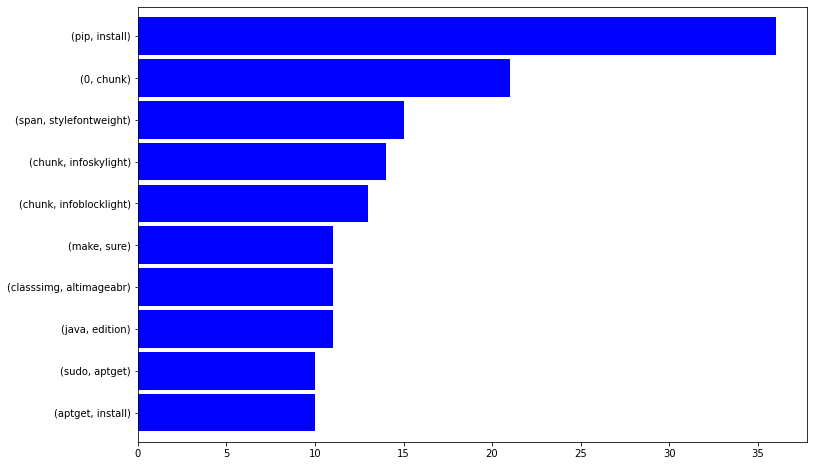

In [39]:
py_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))

<AxesSubplot:>

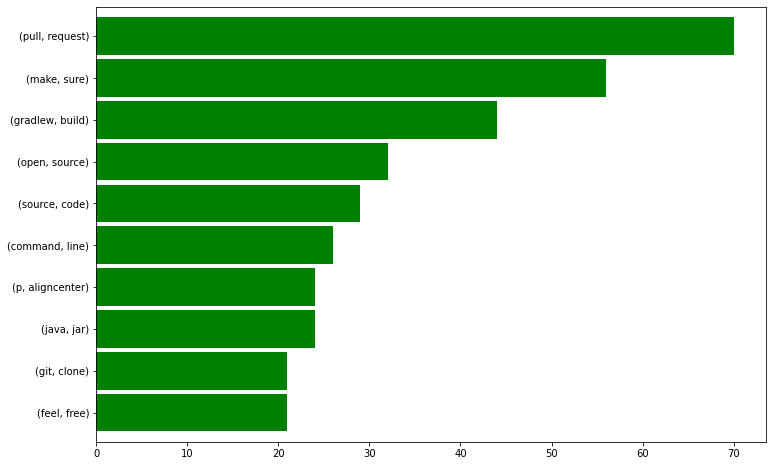

In [41]:
jv_bigrams.sort_values().plot.barh(color="green", width=.9, figsize=(12, 8))

<AxesSubplot:>

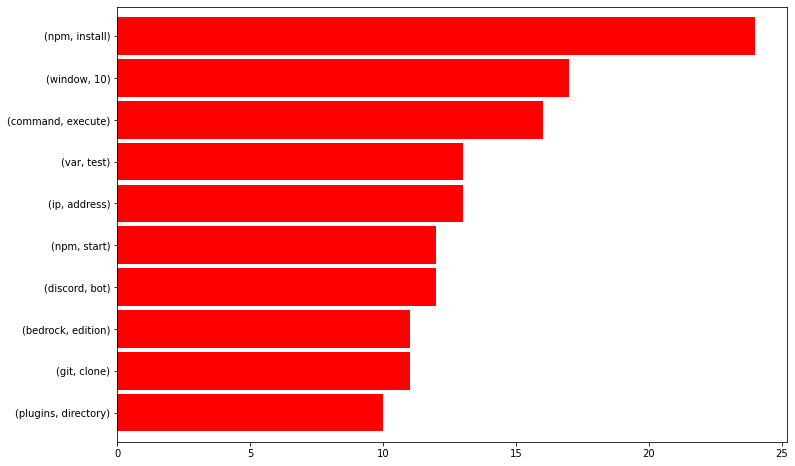

In [42]:
js_bigrams.sort_values().plot.barh(color='red', width=.9, figsize=(12, 8))

<AxesSubplot:>

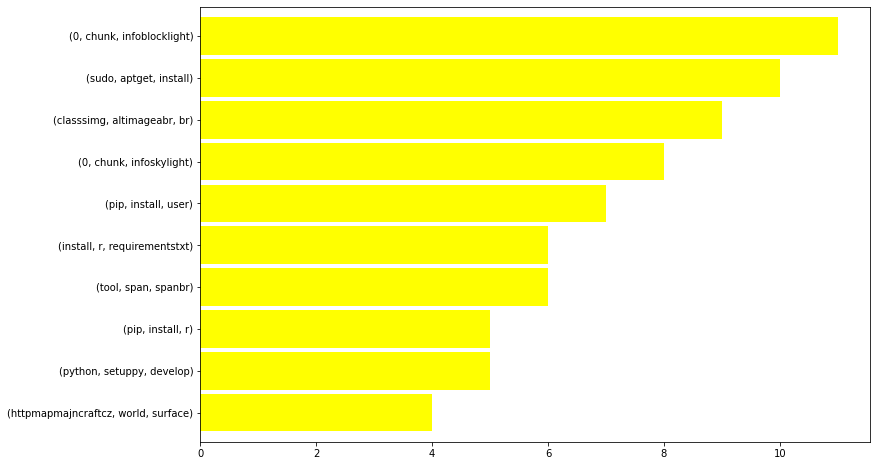

In [43]:
py_trigrams.sort_values().plot.barh(color='yellow', width=.9, figsize=(12, 8))

<AxesSubplot:>

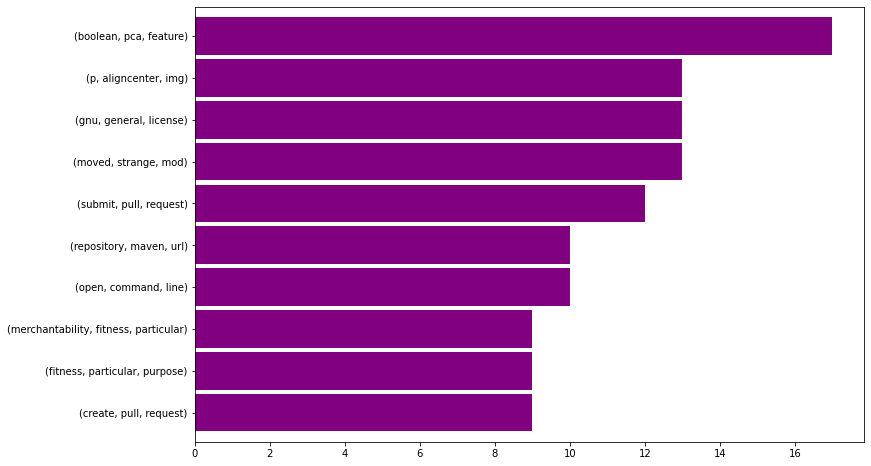

In [44]:
jv_trigrams.sort_values().plot.barh(color='purple', width=.9, figsize=(12, 8))

<AxesSubplot:>

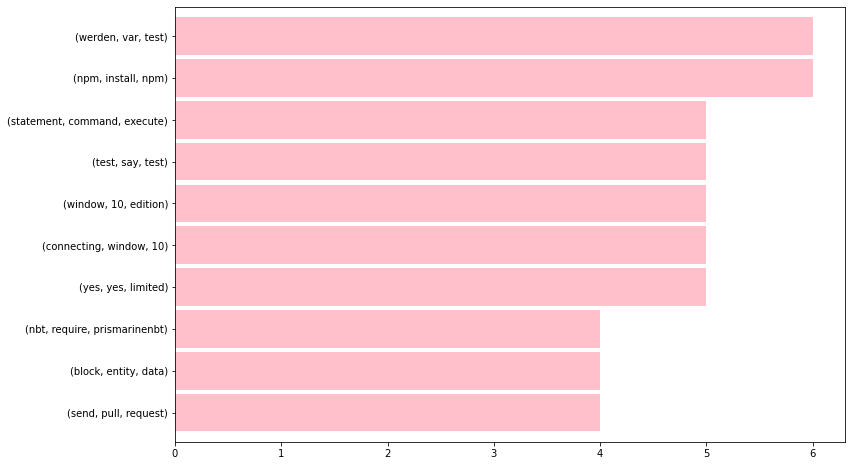

In [45]:
js_trigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(12, 8))